In [7]:
import sys
!{sys.executable} -m pip install pyarrow

     ---------------------------------------- 21.5/21.5 MB 8.3 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

In [2]:
class ProcessGameState():
    def __init__(self, filename):
        self.df = pd.read_parquet(filename, engine='pyarrow')

    def checkBoundary(self,c, boundary): # uses the raycast odd number rule to detect if a point is within the boundaries of a polygon
        x,y,z = c
        if z>421 or z<285: # first check z bound
            return False
        else: # then implement raycast algorithm
            count = 0
            
            for edge in boundary:
                (x1, y1), (x2, y2) = edge
                if (y < y1) != (y<y2) and x < x1 + ((y-y1)/(y2-y1))*(x2-x1):
                    count +=1

            return count%2 == 1

    def getBoundaryRows(self, boundary): # get rows filtered by certain boundary given edges of said boundary
        withinBoundary = []
        for row in self.df.iterrows():
            c = (row[1].x, row[1].y, row[1].z) # create list to hold singular xyz coordinates for each row
            if self.checkBoundary(c, boundary):
                 withinBoundary.append(row[0])
        return withinBoundary # return list of all rows that fall within the given boundary
    
    def getRows(self, area, team, side): # get rows filtered by area, team, and side
        rows = []
        for row in self.df.iterrows():
            row = row[1]
            if ((area == row['area_name']) and (team == row['team']) and (side == row['side']) and (row['is_alive'])):
                rows.append(row)
        return rows

In [3]:
p1 = ProcessGameState('game_state_frame_data.parquet') #name of file here
boundary_points = [[-1735, 250], [-2024, 398], [-2806, 742], [-2472, 1233], [-1565, 580], [-1735, 250], [-1735, 250]]
boundary = [((-1735, 250),(-2024,398)), ((-2024,398), (-2806, 742)),((-2806,742), (-2472, 1233)), ((-2472, 1233),(-1565, 580)), ((-1565, 580), (-1735,250))] #edges of boundary defined here
rows = p1.getBoundaryRows(boundary)


In [4]:
coords = [] #all coords that fall within the specified boundary
coordsT = [] #filtered to only include T side from the above coordinates

for i in rows:
    row = p1.df.iloc[i]
    player = row['player']
    team = row['team']
    side = row['side']
    r = row['round_num']
    x, y= row['x'], row['y']
    coords.append((x,y))
    
    if team == "Team2" and side == 'T': # filtering for rows concerning Team2 on T side in the specified boundary
        print(str(r) +" " +player) #print the player and round number
        coordsT.append((x,y))

16 Player5
16 Player5
16 Player5
16 Player5
16 Player5
16 Player5
16 Player5
16 Player5
16 Player9
16 Player9
16 Player9
16 Player9
16 Player9
16 Player9
16 Player9
16 Player9
16 Player9
16 Player9
16 Player9


In [18]:
def extractWeaponClass(row):
    weapons = []
    for item in row['inventory']:
        weapons.append(item['weapon_class'])
    return weapons

rows = p1.getBoundaryRows(boundary)
for i in rows: # print some examples of extracted inventories
    if i<20000:
        row = p1.df.iloc[i]
        print(extractWeaponClass(row))

['Pistols']
['Pistols']
['Pistols']
['Pistols']
['Pistols']
['Pistols']
['Pistols']
['Pistols']
['Pistols']
['Pistols']
['Pistols']
['Pistols', 'Rifle']
['Rifle', 'Pistols']
['Rifle', 'Pistols']
['Rifle', 'Pistols']
['Rifle', 'Pistols']
['Rifle', 'Pistols']
['Rifle', 'Pistols']
['Rifle', 'Pistols']
['Rifle', 'Pistols']
['Rifle', 'Pistols']
['Rifle', 'Pistols']
['Pistols', 'Rifle']
['Pistols', 'Rifle']
['Rifle', 'Pistols']
['Pistols', 'Rifle']
['Pistols', 'Rifle']
['Rifle', 'Pistols']
['Rifle', 'Pistols']
['Rifle', 'Pistols']
['Rifle', 'Pistols']
['Rifle', 'Pistols']
['Pistols', 'Rifle']
['Pistols', 'Rifle']
['Pistols', 'Rifle']
['Rifle', 'Pistols']
['Pistols', 'Rifle']
['Rifle', 'Pistols']
['Rifle', 'Pistols']
['Rifle', 'Pistols']
['Pistols', 'Rifle']
['Rifle', 'Pistols']
['Rifle', 'Pistols']
['Rifle', 'Pistols']
['Rifle', 'Pistols']
['Rifle', 'Pistols']
['Rifle', 'Pistols']
['Rifle', 'Pistols']
['Rifle', 'Pistols']
['Pistols', 'Rifle']
['Rifle', 'Pistols']
['Rifle', 'Pistols']
['Rifle

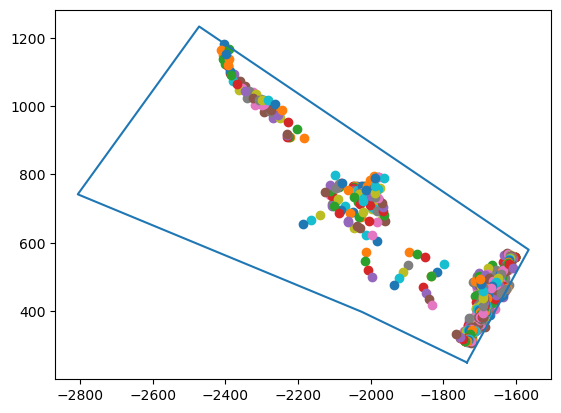

In [10]:
xs = []
ys = []
for coord in coords: #scatter plot for all rows with coordinates in boundary
    plt.scatter(coord[0], coord[1])
for point in boundary_points: #showing the boundary
    xs.append(point[0])
    ys.append(point[1])
    
plt.plot(xs, ys)



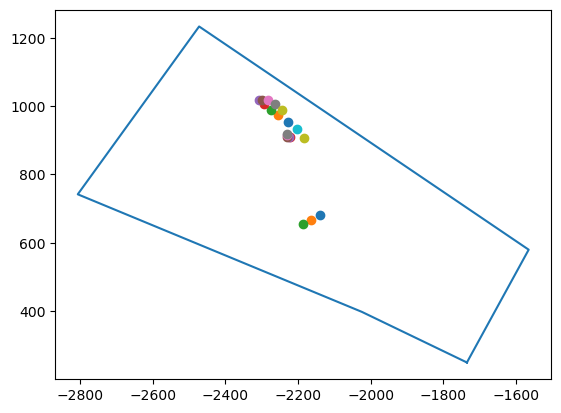

In [8]:
xs = []
ys = []
for coord in coordsT:
    plt.scatter(coord[0], coord[1])
for point in boundary_points: #showing the boundary
    xs.append(point[0])
    ys.append(point[1])
plt.plot(xs, ys)

According to the above output, Team 2 only ever entered the area of interest during 1 round with 2 of their players.
Thus it appears that attacking through the light blue boundary was not a common strategy for Team 2 on T side

In [184]:
def enterArea(rows):# function which returns a 2d array indexed by round number, within each round contains rows of data for first instance of player data for that round
    playerIndex = -1
    rows_by_round = np.empty(shape=(15, 5), dtype=object)
    tRound = 0
    tPlayer = ''
    for row in rows: # rows are already sorted by player and by timer in round so we just need to find the first instance per player per round
        player = row['player']
        if player != tPlayer:
            playerIndex+=1
        round_num = row['round_num']
        if round_num != tRound: # change in round means we can input new row
            rows_by_round[round_num-16][playerIndex] = row
        tRound = round_num
        tPlayer = player
    return rows_by_round
    
def getTimer(rows, weaponCount):  
    sorted_rows = sorted(rows, key=lambda x: x['seconds'], reverse=False) #sort by lowest amount of seconds
    print("Requirements met at: "+ str(sorted_rows[weaponCount-1]['seconds'])+" seconds")
    return sorted_rows[weaponCount-1]['seconds']
    

In [189]:
def getAvgTime(p, area, team, side, weaponCount): # function to get average time entering a certain area by a team on a specific side with a specified number of SMGs or Rifles
    rows = p.getRows(area, team, side)
    rows_by_round = enterArea(rows)
    
    roundCount = 0
    timer = 0
    rifleRows=[]
    
    for i in range(15): #traverse the 2d array to find rows with rifle or SMG in inventory
        if len(rifleRows) >=2:
            roundCount+=1
            timer += getTimer(rifleRows, weaponCount)
        rifleRows=[]
        for j in range(5):
            row = rows_by_round[i][j]
            if (row is not None):
                if "Rifle" or "SMG" in extractWeaponClass(row):
                    print("RIFLE or SMG at: " + str(row['seconds'])+" seconds in round: "+str(row['round_num']))
                    rifleRows.append(row)
    if len(rifleRows) >=2: # edge case to add final time added for last round
            roundCount+=1
            timer += getTimer(rifleRows, weaponCount)
            
    return (timer/roundCount)  


time = getAvgTime(p1, "BombsiteB", "Team2", "T", 2) # Retrieving average timer for Team 2 on T side to enter BombsiteB with atleast 2 rifles or SMGs
print("Average timer for Team 2 on T side to enter BombsiteB with atleast 2 rifles or SMGs is :" + str(time)+ " seconds")

RIFLE or SMG at: 51 seconds in round: 16
RIFLE or SMG at: 21 seconds in round: 16
RIFLE or SMG at: 52 seconds in round: 16
RIFLE or SMG at: 45 seconds in round: 16
RIFLE or SMG at: 48 seconds in round: 16
Requirements met at: 45 seconds
RIFLE or SMG at: 21 seconds in round: 21
RIFLE or SMG at: 19 seconds in round: 21
Requirements met at: 21 seconds
RIFLE or SMG at: 30 seconds in round: 25
RIFLE or SMG at: 103 seconds in round: 26
RIFLE or SMG at: 32 seconds in round: 28
RIFLE or SMG at: 34 seconds in round: 28
RIFLE or SMG at: 28 seconds in round: 28
RIFLE or SMG at: 29 seconds in round: 28
RIFLE or SMG at: 39 seconds in round: 28
Requirements met at: 29 seconds
RIFLE or SMG at: 39 seconds in round: 30
RIFLE or SMG at: 41 seconds in round: 30
RIFLE or SMG at: 36 seconds in round: 30
Requirements met at: 39 seconds
33.5


5101


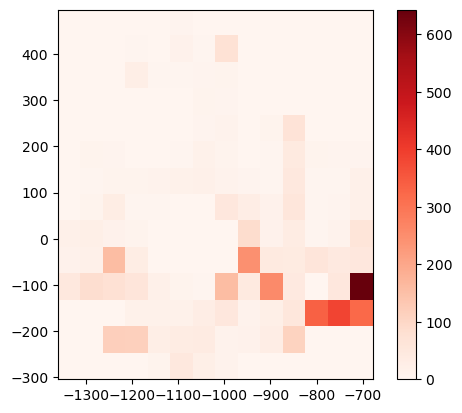

In [15]:
from matplotlib.pyplot import cm
bSiteCTRows = p1.getRows('BombsiteB', 'Team2', 'CT')
x = []
y = []
for rows in bSiteCTRows:
    x.append(rows['x'])
    y.append(rows['y'])
print(len(x))
heatmap, xedges, yedges = np.histogram2d(x, y, bins=14) 
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]  
plt.clf()  
plt.imshow(heatmap, extent=extent, cmap=cm.Reds)  
plt.colorbar()
plt.show() 